In [1]:
import torch
import esm

import pandas as pd
from tqdm import tqdm
from Bio import SeqIO
import itertools
from typing import List, Tuple
import numpy as np

In [2]:
import os

In [3]:
# df = pd.read_csv('/nethome/kgeorge/workspace/DomainPrediction/Data/al_test_experiments/Evolvepro/brenan.csv')
df = pd.read_csv('/nethome/kgeorge/workspace/DomainPrediction/Data/al_test_experiments/Envision/TEM1.csv')

In [4]:
df.head()

,variant_id,id,reported_fitness,aa1,aa2,wt_mut,mut_type,position,Variant,scaled_effect1
0,beta-lactamase_P20P,TEM-1_P20P,0.581033,P,P,PP,synonymous,20,P20P,1.581033
1,beta-lactamase_D207D,TEM-1_D207D,0.425631,D,D,DD,synonymous,207,D207D,1.425631
2,beta-lactamase_A215A,TEM-1_A215A,0.422813,A,A,AA,synonymous,215,A215A,1.422813
3,beta-lactamase_C75C,TEM-1_C75C,0.415532,C,C,CC,synonymous,75,C75C,1.415532
4,beta-lactamase_N134N,TEM-1_N134N,0.396966,N,N,NN,synonymous,134,N134N,1.396966


In [6]:
model_name = 'esm1v_t33_650M_UR90S_1.pt'
model_loc = '/data/users/kgeorge/workspace/esm1v'
model, alphabet = esm.pretrained.load_model_and_alphabet(os.path.join(model_loc, model_name))
model.eval()
model = model.cuda()
batch_converter = alphabet.get_batch_converter()

/nethome/kgeorge/miniconda3/envs/workspace-esm/lib/python3.10/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


In [7]:
# brenen_seq = "MAAAAAAGAGPEMVRGQVFDVGPRYTNLSYIGEGAYGMVCSAYDNVNKVRVAIKKISPFEHQTYCQRTLREIKILLRFRHENIIGINDIIRAPTIEQMKDVYIVQDLMETDLYKLLKTQHLSNDHICYFLYQILRGLKYIHSANVLHRDLKPSNLLLNTTCDLKICDFGLARVADPDHDHTGFLTEYVATRWYRAPEIMLNSKGYTKSIDIWSVGCILAEMLSNRPIFPGKHYLDQLNHILGILGSPSQEDLNCIINLKARNYLLSLPHKNKVPWNRLFPNADSKALDLLDKMLTFNPHKRIEVEQALAHPYLEQYYDPSDEPIAEAPFKFDMELDDLPKEKLKELIFEETARFQPGYRS"
TEM1_seq = "MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"

In [8]:
data = [
    ("protein1", TEM1_seq),
    ]
batch_labels, batch_strs, batch_tokens = batch_converter(data)

In [9]:
len(TEM1_seq), batch_tokens.shape

(286, torch.Size([1, 288]))

In [10]:
all_token_probs = []
for i in tqdm(range(batch_tokens.size(1))):
    batch_tokens_masked = batch_tokens.clone()
    batch_tokens_masked[0, i] = alphabet.mask_idx ## this adds mask at pos i
    with torch.no_grad():
        token_probs = torch.log_softmax(
            model(batch_tokens_masked.cuda())["logits"], dim=-1
        )
    all_token_probs.append(token_probs[:, i]) ## log prog at pos i when i is maked
token_probs = torch.cat(all_token_probs, dim=0).unsqueeze(0)

100%|██████████| 288/288 [00:37<00:00,  7.64it/s]


In [11]:
token_probs

tensor([[[  0.0000, -34.8267, -34.5473,  ..., -36.8701, -37.5448, -34.5314],
         [-19.9499, -29.4049, -29.5113,  ..., -26.3284, -25.0726, -29.5282],
         [-19.1971, -23.0624, -23.1555,  ..., -19.2822, -19.5132, -23.2030],
         ...,
         [-20.2076, -25.1386, -25.3410,  ..., -19.3174, -19.8407, -24.9457],
         [-19.3462, -24.3120, -24.5337,  ..., -19.7202, -20.1635, -24.3507],
         [-18.7833, -23.6838, -23.7793,  ..., -19.5362, -19.6738, -23.7844]]],
       device='cuda:0')

In [12]:
def label_row(row, sequence, token_probs, alphabet, offset_idx):
    wt, idx, mt = row[0], int(row[1:-1]) - offset_idx, row[-1]
    assert sequence[idx] == wt, "The listed wildtype does not match the provided sequence"

    wt_encoded, mt_encoded = alphabet.get_idx(wt), alphabet.get_idx(mt)

    # add 1 for BOS
    score = token_probs[0, 1 + idx, mt_encoded] - token_probs[0, 1 + idx, wt_encoded]
    return score.item()

In [13]:
alphabet.all_special_tokens

['<eos>', '<unk>', '<pad>', '<cls>', '<mask>']

In [14]:
# label_row(
#     'H24C',
#     sequence,
#     token_probs,
#     alphabet,
#     24,
# )

In [31]:
df.head()

,variant_id,id,reported_fitness,aa1,aa2,wt_mut,mut_type,position,Variant,scaled_effect1
0,beta-lactamase_P20P,TEM-1_P20P,0.581033,P,P,PP,synonymous,20,P20P,1.581033
1,beta-lactamase_D207D,TEM-1_D207D,0.425631,D,D,DD,synonymous,207,D207D,1.425631
2,beta-lactamase_A215A,TEM-1_A215A,0.422813,A,A,AA,synonymous,215,A215A,1.422813
3,beta-lactamase_C75C,TEM-1_C75C,0.415532,C,C,CC,synonymous,75,C75C,1.415532
4,beta-lactamase_N134N,TEM-1_N134N,0.396966,N,N,NN,synonymous,134,N134N,1.396966


In [30]:
for i, row in df.iterrows():
    pos = int(row['Variant'][1:-1]) - 1
    assert int(row['position']) == pos+1

    if row['mut_type'] == 'missense':
        if TEM1_seq[pos] != row['Variant'][0]:
            print(TEM1_seq[pos], row['Variant'])

In [32]:
df_copy = df.copy()

In [33]:
df = df[df['mut_type'] == 'missense']

In [34]:
df[model_name] = df.apply(
    lambda row: label_row(
        row['Variant'],
        TEM1_seq,
        token_probs,
        alphabet,
        1,
    ),
    axis=1,
)

/tmp/ipykernel_2062049/3286143366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[model_name] = df.apply(


In [35]:
df.columns

Index(['variant_id', 'id', 'reported_fitness', 'aa1', 'aa2', 'wt_mut',
       'mut_type', 'position', 'Variant', 'scaled_effect1',
       'esm1v_t33_650M_UR90S_1.pt'],
      dtype='object')

<Axes: >

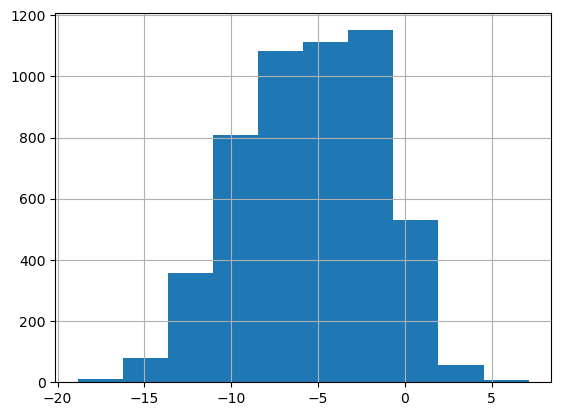

In [37]:
df['esm1v_t33_650M_UR90S_1.pt'].hist()

In [40]:
import matplotlib.pyplot as plt
from scipy import stats

In [54]:
fit_median = df_copy.loc[df_copy['mut_type'] == 'synonymous', 'reported_fitness'].median()
per_1 = df_copy.loc[df_copy['mut_type'] == 'missense', 'reported_fitness'].quantile(0.01)
per_1_median = df_copy.loc[(df_copy['mut_type'] == 'missense') & (df_copy['reported_fitness']<=per_1), 'reported_fitness'].median()

In [55]:
df['scaled'] = (df['reported_fitness'] - fit_median)/(-per_1_median) + 1

In [56]:
df.head()

,variant_id,id,reported_fitness,aa1,aa2,wt_mut,mut_type,position,Variant,scaled_effect1,esm1v_t33_650M_UR90S_1.pt,scaled
71,beta-lactamase_F58N,TEM-1_F58N,1.537240,F,N,FN,missense,58,F58N,1.142208,0.546880,1.143566
101,beta-lactamase_L19W,TEM-1_L19W,1.053720,L,W,LW,missense,19,L19W,1.094952,-3.889126,1.096310
116,beta-lactamase_A15Y,TEM-1_A15Y,0.823567,A,Y,AY,missense,15,A15Y,1.072459,-3.873943,1.073817
123,beta-lactamase_A182M,TEM-1_A182M,0.768011,A,M,AM,missense,182,A182M,1.067029,-1.791364,1.068387
124,beta-lactamase_S281F,TEM-1_S281F,0.768011,S,F,SF,missense,281,S281F,1.067029,0.016878,1.068387


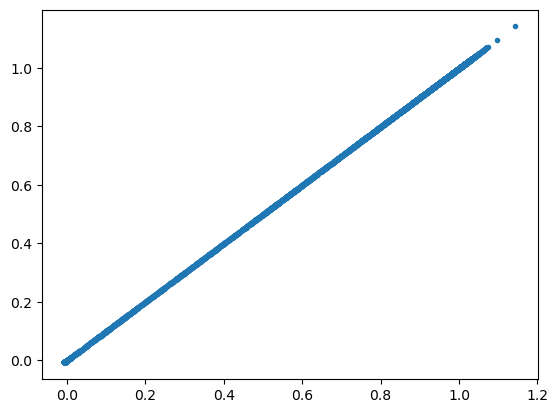

In [58]:
plt.plot(df['scaled'], df['scaled_effect1'], '.')

0.67


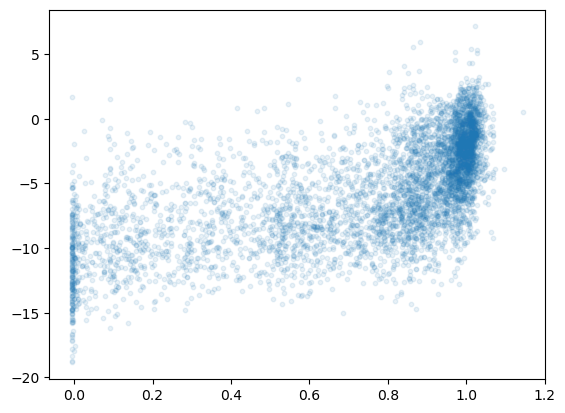

In [57]:
corr = stats.spearmanr(df['scaled'], df['esm1v_t33_650M_UR90S_1.pt'])
s_corr = round(corr.statistic, 2)
print(s_corr)
plt.scatter(df['scaled'], df['esm1v_t33_650M_UR90S_1.pt'], s=10, alpha=0.1)

0.67


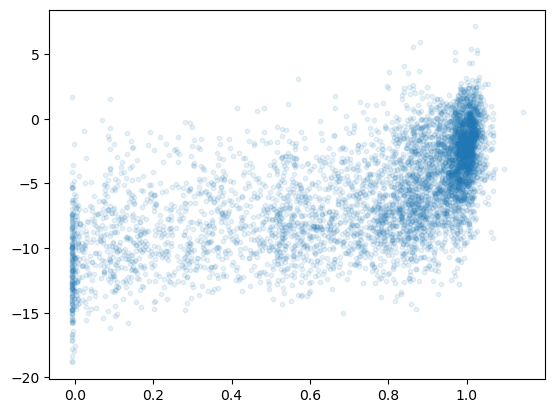

In [42]:
corr = stats.spearmanr(df['scaled_effect1'], df['esm1v_t33_650M_UR90S_1.pt'])
s_corr = round(corr.statistic, 2)
print(s_corr)
plt.scatter(df['scaled_effect1'], df['esm1v_t33_650M_UR90S_1.pt'], s=10, alpha=0.1)

0.67


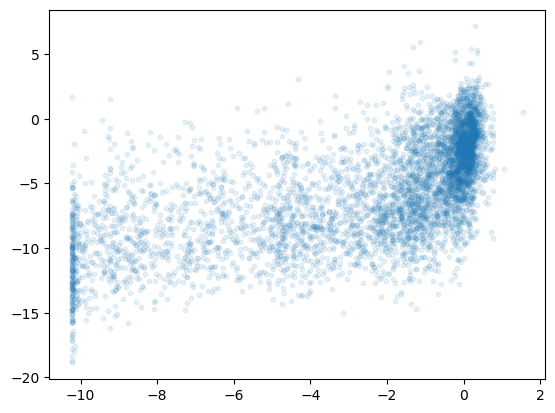

In [43]:
corr = stats.spearmanr(df['reported_fitness'], df['esm1v_t33_650M_UR90S_1.pt'])
s_corr = round(corr.statistic, 2)
print(s_corr)
plt.scatter(df['reported_fitness'], df['esm1v_t33_650M_UR90S_1.pt'], s=10, alpha=0.1)